In [25]:
import pandas as pd
import numpy as np
import re
import pickle
from scipy.sparse import hstack
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Import various classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import make_scorer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Creation

*insert andrew's code combine all datasets*

In [7]:
clean_avg = pd.read_csv('aidata_clean_avg.csv')
clean_avg.head()

,Question,Human,AI,Question_length,Human_length,AI_length,Question_special_count,Human_special_count,AI_special_count,avg_special_char_diff
0,1) Write short note about Transition Probabili...,Transition Probability Matrix P is used in Mar...,A transition probability matrix is a mathemati...,56,388,629,2,46,9,29.333333
1,2) Write short note about Bayes' Rule,P (B|A) = P(A|B)P(B) / P(A)\n = P(A...,Bayes' Rule is a fundamental theorem in probab...,37,131,792,2,39,38,24.666667
2,3) What is the meaning of outcome in probability?,The outcome of probability is the possible res...,"In probability, an outcome refers to a specifi...",49,133,610,2,3,16,9.333333
3,4) How do we transform a process to a Markov c...,The state of the system at time t+1 depends on...,Transforming a process into a Markov chain inv...,51,203,1357,2,58,22,37.333333
4,5) Write short note about Continuous probabili...,A probability distribution in which the random...,A continuous probability distribution is a typ...,63,170,977,2,14,16,9.333333


Data Cleaning and Pre-Processing

In [8]:
def preprocess_text(text):
        # Lowercase
        text = text.lower()
        # Remove punctuation and special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        # Remove stopwords
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return " ".join(filtered_tokens)
# removed puncatuation and stop words for traiditional classifiers. Should be retained for Bert/deep learning
def generic_preprocessing(df):
    human = df[['Question_length', 'Question_special_count', 'avg_special_char_diff', 'Human_length', 'Human_special_count']].copy()
    human['Response'] = df['Human']
    human['length'] = human['Human_length']
    human['special_count'] = human['Human_special_count']
    human['Is_AI'] = 0
    human = human.drop(columns=['Human_length', 'Human_special_count'])

    ai = df[['Question_length', 'Question_special_count', 'avg_special_char_diff', 'AI_length', 'AI_special_count']].copy()
    ai['Response'] = df['AI']
    ai['length'] = ai['AI_length']
    ai['special_count'] = ai['AI_special_count']
    ai['Is_AI'] = 1
    ai = ai.drop(columns=['AI_length', 'AI_special_count'])

    data = pd.concat([human, ai], ignore_index=True)
    # Apply text preprocessing to a text column
    data['processed_text'] = data['Response'].apply(preprocess_text)
    return data


In [9]:
processed = generic_preprocessing(clean_avg)

# drop irrelevant 'Response' column
processed = processed.drop(columns=['Response', 'avg_special_char_diff'])

# scale numeric columns using z-score scaling
scaler = StandardScaler()
num_cols = ['Question_length', 'Question_special_count', 'length', 'special_count']
data_scaled = scaler.fit_transform(processed[num_cols])
data_scaled = pd.DataFrame(data_scaled, columns=num_cols)
processed_scaled = processed.drop(columns=num_cols)
processed_scaled = pd.concat([data_scaled, processed_scaled], axis=1)

processed_scaled.head()

,Question_length,Question_special_count,length,special_count,Is_AI,processed_text
0,0.712344,0.212198,-0.639383,1.309963,0,transition probability matrix p used markov ch...
1,-0.733071,0.212198,-1.112995,0.941450,0,p ba pabpb pa pabpb pabpb pabpb posterior prio...
2,0.179823,0.212198,-1.109309,-0.953759,0,outcome probability possible result rendom exp...
3,0.331972,0.212198,-0.980310,1.941699,0,state system time depends state system time px...
4,1.244865,0.212198,-1.041124,-0.374667,0,probability distribution random variable x tak...


Exploratory Data Analysis

*to be added by Basit/Andrew*

Feature Engineering

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Assume processed['processed_text'] is a pandas Series containing your text data
X_text = processed_scaled['processed_text']

# Fit the vectorizer to the text and transform it into token count vectors
X_vectorized = vectorizer.fit_transform(X_text)

# combine all columns
X_combined = hstack([X_vectorized, data_scaled.values])

# X_vectorized is now a sparse matrix of shape (n_samples, n_features)
print("Shape of vectorized text data:", X_combined.shape)

Shape of vectorized text data: (3986, 6933)


In [11]:
# 80-20 train-test split
X = X_combined
y = processed_scaled['Is_AI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (3188, 6933) (3188,)
Testing set shape: (798, 6933) (798,)


Number of components to reach 95% variance: 482


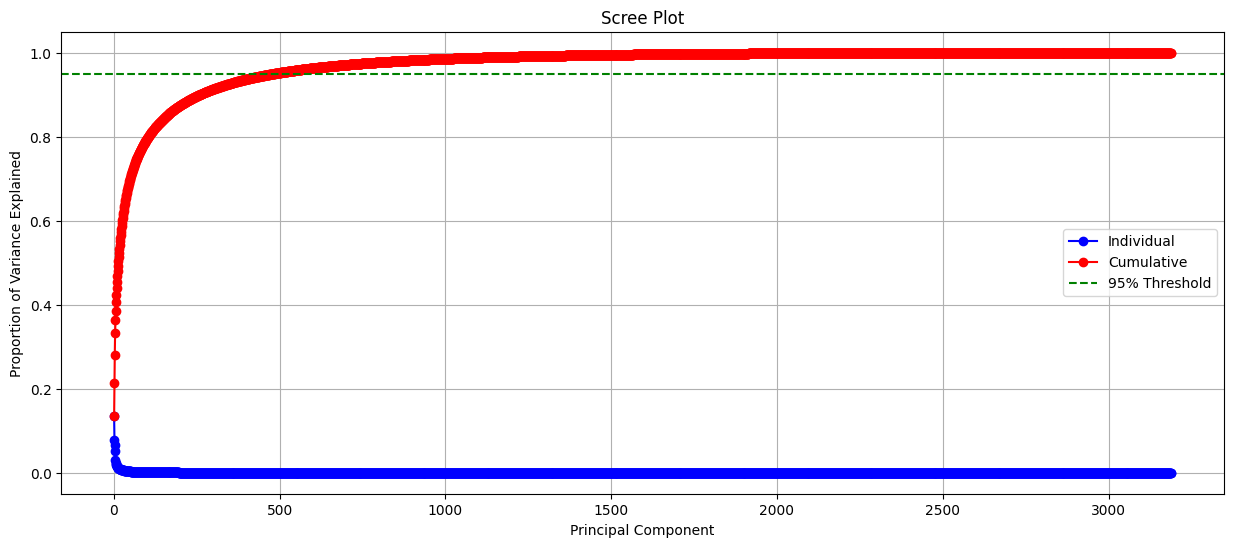

In [14]:
# Scree plot to choose number of principle components

# perform SVD
U, s, Vt = np.linalg.svd(X_train.toarray())  # Convert sparse matrix to dense if needed
V = Vt.T

fig = plt.figure(figsize=(15, 6))
var_exp = s**2 / np.sum(s**2)
cum_var_exp = np.cumsum(var_exp)

plt.plot(range(1, len(var_exp) + 1), var_exp, 'bo-', label='Individual')
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, 'ro-', label='Cumulative')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Threshold')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.grid(True)

num_components_95 = np.argmax(cum_var_exp >= 0.95) + 1  # +1 because index starts at 0
print(f"Number of components to reach 95% variance: {num_components_95}")

In [15]:
# Reduce to 482 dimensions using PCA
# apply pca post test-train split to prevent info leakage and overfitting b/w train and test sets

pca = PCA(n_components=482)
X_train_pca = pca.fit_transform(X_train.toarray())  # Converting sparse matrix to dense
X_test_pca = pca.transform(X_test.toarray())


In [18]:
# Output proportion of variance explained by first 5 components
first_5_var = pca.explained_variance_ratio_[:5]
print("Proportion of variance explained by first 5 components:")
for i, var in enumerate(first_5_var, 1):
    print(f"PC{i}: {var:.4f}")

Proportion of variance explained by first 5 components:
PC1: 0.0928
PC2: 0.0729
PC3: 0.0598
PC4: 0.0549
PC5: 0.0335


In [23]:
pca_df = pd.DataFrame(X_train_pca[:, :3], columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
pca_df['Is_AI'] = y_train.values
fig = px.scatter_3d(pca_df, 
                    x='PCA Component 1', 
                    y='PCA Component 2', 
                    z='PCA Component 3', 
                    color='Is_AI', 
                    color_continuous_scale='viridis',
                    title="Distinguishability by First 3 Principle Components",
                    labels={'Is_AI': 'Is AI'}
                   )
fig.show()
pio.write_json(fig, "pca_plot.json")

Pre-Processing

Modelling

In [ ]:
# Define a dictionary of classification models
classifiers = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    #'Naive Bayes': MultinomialNB(), # removing since not good for pca transofrmed data
    'SVM': LinearSVC(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'MLPClassifier' : MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

param_grid = {
    'Logistic Regression': {'clf__C': [0.01, 0.1, 1, 10]},
    'SVM': {'clf__C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'clf__max_depth': [5, 10, 20, None]},
    'Random Forest': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [5, 10, 20, None]},
    'Gradient Boosting': {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 0.2]},
    'K-Nearest Neighbors': {'clf__n_neighbors': [3, 5, 7, 10, 15, 20]},
    'MLPClassifier': {'clf__hidden_layer_sizes': [(50,), (100,), (150,)], 'clf__alpha': [0.0001, 0.001, 0.01]}
}

results = {}

# Loop through models, build pipelines and evaluate
for name, clf in classifiers.items():
    print("=" * 40)
    print(f"{name} Hyperparameter Tuning & Cross-Validation")

    pipeline = Pipeline([
        ('clf', clf)  
    ])
    
    # hyperparameter tuning with 5-fold cross validation
    grid = param_grid.get(name, {})
    grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='accuracy', n_jobs=-1) 
    grid_search.fit(X_train_pca, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)
    
    cv_results = grid_search.cv_results_
    mean_accuracy = np.mean(cv_results['mean_test_score'])
    std_accuracy = np.std(cv_results['mean_test_score'])
    confidence_interval = (mean_accuracy - 1.96 * std_accuracy / np.sqrt(len(y_train)),
                           mean_accuracy + 1.96 * std_accuracy / np.sqrt(len(y_train)))
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"95% Confidence Interval: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")

    # Fit the pipeline on the training data
    pipeline.fit(X_train_pca, y_train)
    
    # Make predictions on the test data
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test_pca)
    train_pred= best_model.predict(X_train_pca)
    
    # Generate and print the classification report for the current model
    report = classification_report(y_test, predictions)
    train_report = classification_report(y_train, train_pred)
    print("="*40)
    print(f"{name} Classification Report:")
    print("-"*10)
    print("Test Report")
    print(report)
    print("-"*10)
    print("Train Report")
    print(train_report)

    results[name] = {
        "Best Parameters": grid_search.best_params_,
        "Best Cross-Validation Score": grid_search.best_score_,
        "Mean Accuracy": mean_accuracy,
        "95% Confidence Interval": confidence_interval,
        "Test Report": classification_report(y_test, predictions, output_dict=True),
        "Train Report": classification_report(y_train, train_pred, output_dict=True)
    }

with open("model_results.pkl", "wb") as f:
    pickle.dump(results, f)

model_names = list(results.keys())
accuracies = [results[m]["Test Report"]["accuracy"] for m in model_names]

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(model_names, accuracies, color='skyblue')
ax.set_title("Test Accuracy Across Models")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)
plt.xticks(rotation=45)
fig.savefig("model_accuracy_plot.png", bbox_inches='tight')


Logistic Regression Hyperparameter Tuning & Cross-Validation
Best Parameters: {'clf__C': 0.1}
Best Cross-Validation Score: 0.8190046406795176
Mean Accuracy: 0.8047
95% Confidence Interval: (0.8043, 0.8050)
Logistic Regression Classification Report:
----------
Test Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       416
           1       0.88      0.79      0.83       382

    accuracy                           0.85       798
   macro avg       0.85      0.85      0.85       798
weighted avg       0.85      0.85      0.85       798

----------
Train Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1577
           1       0.91      0.83      0.87      1611

    accuracy                           0.87      3188
   macro avg       0.87      0.87      0.87      3188
weighted avg       0.87      0.87      0.87      3188

SVM Hyperparameter Tuning & Cross-Validation
Best 

KeyError: 'Test Accuracy'

In [ ]:
## Using Tensor flow & BERT (to be explored)
'''
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# --- 3. Tokenize and Pad Sequences ---
# You can adjust num_words to control the vocabulary size.
num_words = 5000
tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)

# Determine the maximum sequence length (or specify a fixed value)
max_length = max(len(seq) for seq in X_seq)
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post')

# --- 4. Train-Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# --- 5. Build the Keras Model ---
# The Embedding layer converts integer sequences into dense vectors.
# GlobalAveragePooling1D is used to aggregate the sequence information.
num_classes = len(np.unique(y_encoded))

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=50, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 6. Train the Model ---
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# --- 7. Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy (Keras Model):", accuracy)

'''